# Form-Filling Agent with LangGraph

This notebook demonstrates how to build an agentic AI application to auto-fill web forms using LangGraph. The agent:

1. Extracts information from initial user messages
2. Identifies missing fields that need additional information
3. Asks the user questions to gather missing information
4. Completes the form when all required fields are filled

This type of agent is useful for simplifying form completion by allowing users to provide information in natural language, rather than filling out each field manually.

## 1. Import Required Libraries

First, we'll import the necessary libraries for building our form-filling agent.

In [ ]:
import os
import asyncio
import json
from typing import Dict, List, Any, Optional, TypedDict, Literal, Union
from uuid import uuid4
from dotenv import load_dotenv
from pprint import pprint

# LangChain imports
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import AzureChatOpenAI

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# Load environment variables
load_dotenv()

True

## 2. Define the Form State

We'll create a custom state structure to track form fields, user inputs, and the current status of the form-filling process.

In [ ]:
# Define form field structure
class FormField(TypedDict):
    """Structure for individual form fields"""
    field_id: str
    label: str
    type: str  # input, select, radio, checkbox, textarea, etc.
    value: Optional[str]
    required: bool
    options: Optional[List[str]]  # For dropdown, radio, etc.
    description: Optional[str]  # Help text
    validation: Optional[str]  # Validation rules

# Define the state structure for our graph
class FormFillerState(TypedDict):
    """State for the form-filling workflow"""
    user_message: str
    form_fields: List[FormField]
    filled_fields: Dict[str, Any]
    missing_fields: List[str]
    current_field: Optional[str]
    conversation_history: List[Dict[str, Any]]
    status: Literal["in_progress", "awaiting_info", "completed"]
    response: str

## 3. Create LLM Configuration

We'll configure the language model (Azure OpenAI) for processing user inputs and extracting form field values.

In [ ]:
# Initialize the model
try:
    model = AzureChatOpenAI(
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
        openai_api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-12-01-preview"),
    )
    print("✅ Azure OpenAI model initialized successfully")
except KeyError as e:
    print(f"❌ Environment variable not found: {e}")
    print("Using a mock model for demonstration purposes...")
    
    # Create a simple mock model for demonstration
    class MockModel:
        async def ainvoke(self, messages):
            prompt = messages[-1].content if hasattr(messages[-1], 'content') else str(messages[-1])
            
            # Simulate response based on prompt content
            if "name" in prompt.lower():
                return AIMessage(content="John Smith")
            elif "email" in prompt.lower():
                return AIMessage(content="john.smith@example.com")
            elif "phone" in prompt.lower():
                return AIMessage(content="555-123-4567")
            elif "address" in prompt.lower():
                return AIMessage(content="123 Main St, Anytown, USA")
            elif "birth" in prompt.lower():
                return AIMessage(content="1985-05-15")
            elif "occupation" in prompt.lower():
                return AIMessage(content="Software Developer")
            elif "extract" in prompt.lower() or "form" in prompt.lower():
                return AIMessage(content="""```json
{
  "filled_fields": {
    "name": "John Smith",
    "email": "john.smith@example.com"
  },
  "missing_fields": ["phone", "address", "birthdate", "occupation"]
}
```""")
            else:
                return AIMessage(content="I've processed your request.")
    
    model = MockModel()
    print("✓ Using mock model for demonstration")

✅ Azure OpenAI model initialized successfully


## 4. Define Form Processing Node

This node processes initial user messages, extracts relevant information, and populates form fields with available data.

In [ ]:
async def analyze_form(state: FormFillerState) -> FormFillerState:
    """
    Analyzes user input and form fields to extract available information and identify missing fields.
    """
    user_message = state["user_message"]
    form_fields = state["form_fields"]
    
    # Create system prompt for form analysis
    system_prompt = """
    You are a form-filling assistant. Analyze the user's message and extract information to fill in form fields.
    For each form field provided, determine:
    1. If the field can be filled based on the user's message
    2. The appropriate value for the field
    3. If additional information is needed
    
    Return a JSON object with the following structure:
    ```json
    {
      "filled_fields": {
        "field_id1": "extracted value1",
        "field_id2": "extracted value2"
      },
      "missing_fields": ["field_id3", "field_id4"]
    }
    ```
    
    Only include fields in filled_fields if you have high confidence in the extracted value.
    Include all fields that need additional information in missing_fields.
    """
    
    # Format form fields for the model
    field_descriptions = []
    for field in form_fields:
        field_desc = f"Field ID: {field['field_id']}\nLabel: {field['label']}\nType: {field['type']}\n"
        if field.get('description'):
            field_desc += f"Description: {field['description']}\n"
        if field.get('options'):
            field_desc += f"Options: {', '.join(field['options'])}\n"
        if field.get('validation'):
            field_desc += f"Validation: {field['validation']}\n"
        field_desc += f"Required: {'Yes' if field.get('required', False) else 'No'}\n"
        field_descriptions.append(field_desc)
    
    all_field_descriptions = "\n\n".join(field_descriptions)
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User message: {user_message}\n\nForm fields:\n{all_field_descriptions}")
    ]
    
    # Add conversation history for context if available
    if state.get("conversation_history"):
        history_context = "Previous conversation:\n"
        for entry in state["conversation_history"]:
            role = "User" if entry["role"] == "user" else "Assistant"
            history_context += f"{role}: {entry['content']}\n"
        messages.append(SystemMessage(content=history_context))
    
    # Get response from the LLM
    response = await model.ainvoke(messages)
    print("Form analysis response:", response.content)
    
    # Parse the model's response
    try:
        # Try to extract JSON from the response
        import re
        
        # Look for JSON in code blocks
        json_match = re.search(r'```(?:json)?\s*\n(.*?)\n```', response.content, re.DOTALL)
        if json_match:
            form_data = json.loads(json_match.group(1))
        else:
            # Fallback to see if the entire response is JSON
            form_data = json.loads(response.content)
            
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        # Handle parsing failure gracefully
        form_data = {
            "filled_fields": {},
            "missing_fields": [field["field_id"] for field in form_fields]
        }
    
    # Update conversation history
    history = state.get("conversation_history", [])
    history.append({"role": "user", "content": user_message})
    
    # Determine next steps based on missing fields
    missing_fields = form_data.get("missing_fields", [])
    filled_fields = form_data.get("filled_fields", {})
    
    # Set status based on whether there are missing fields
    status = "completed" if not missing_fields else "awaiting_info"
    current_field = missing_fields[0] if missing_fields else None
    
    # Generate response based on analysis
    if status == "completed":
        response_text = "Great! I've filled out the entire form based on your information."
    else:
        # Find the current field details
        current_field_details = next((f for f in form_fields if f["field_id"] == current_field), {})
        field_label = current_field_details.get("label", current_field)
        
        response_text = f"I need some additional information. Can you provide the {field_label}?"
        if current_field_details.get("description"):
            response_text += f" ({current_field_details['description']})"
        if current_field_details.get("options"):
            options_text = ", ".join(current_field_details["options"])
            response_text += f" Options are: {options_text}"
    
    history.append({"role": "assistant", "content": response_text})
    
    return {
        **state,
        "filled_fields": filled_fields,
        "missing_fields": missing_fields,
        "current_field": current_field,
        "conversation_history": history,
        "status": status,
        "response": response_text
    }

## 5. Define User Interaction Node

This node processes the user's response to requests for additional information. It extracts the specific field value from the user's message and updates the form state accordingly.

In [ ]:
async def process_field_input(state: FormFillerState) -> FormFillerState:
    """
    Processes user input for a specific requested field.
    """
    user_message = state["user_message"]
    current_field = state["current_field"]
    form_fields = state["form_fields"]
    filled_fields = state["filled_fields"].copy()
    missing_fields = state["missing_fields"].copy()
    
    # Get the current field details
    current_field_details = next((f for f in form_fields if f["field_id"] == current_field), None)
    
    if not current_field_details:
        return state
    
    # Create system prompt for field validation
    system_prompt = f"""
    You are a form-filling assistant. The user is providing information for the field: {current_field_details['label']}.
    
    Field details:
    - Type: {current_field_details['type']}
    - Required: {'Yes' if current_field_details.get('required', False) else 'No'}
    {f"- Options: {', '.join(current_field_details['options'])}" if current_field_details.get('options') else ""}
    {f"- Validation: {current_field_details['validation']}" if current_field_details.get('validation') else ""}
    
    Extract the appropriate value from the user's response and validate it according to the field requirements.
    Return only the extracted value as it should be entered in the form field.
    """
    
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"User response for {current_field_details['label']}: {user_message}")
    ]
    
    # Get response from the LLM
    response = await model.ainvoke(messages)
    field_value = response.content.strip()
    
    print(f"Extracted value for {current_field}: {field_value}")
    
    # Update the filled_fields and missing_fields
    filled_fields[current_field] = field_value
    if current_field in missing_fields:
        missing_fields.remove(current_field)
    
    # Update conversation history
    history = state["conversation_history"]
    history.append({"role": "user", "content": user_message})
    
    # Determine next steps
    next_field = missing_fields[0] if missing_fields else None
    
    if not next_field:
        status = "completed"
        response_text = "Great! I've filled out the entire form. Here's a summary of the information:"
        for field in form_fields:
            field_id = field["field_id"]
            if field_id in filled_fields:
                response_text += f"\n- {field['label']}: {filled_fields[field_id]}"
    else:
        status = "awaiting_info"
        next_field_details = next((f for f in form_fields if f["field_id"] == next_field), {})
        field_label = next_field_details.get("label", next_field)
        
        response_text = f"Thanks! Now, can you provide the {field_label}?"
        if next_field_details.get("description"):
            response_text += f" ({next_field_details['description']})"
        if next_field_details.get("options"):
            options_text = ", ".join(next_field_details["options"])
            response_text += f" Options are: {options_text}"
    
    history.append({"role": "assistant", "content": response_text})
    
    return {
        **state,
        "filled_fields": filled_fields,
        "missing_fields": missing_fields,
        "current_field": next_field,
        "conversation_history": history,
        "status": status,
        "response": response_text
    }

## 6. Define the Human-in-the-Loop Node

This is a placeholder node for receiving human input. In a real system, this would be an interrupt point where the system waits for user input.

In [ ]:
def human_input(state: FormFillerState) -> FormFillerState:
    """
    Placeholder node for receiving human input. In a real system, this would be an interrupt
    point where the system waits for user input.
    """
    return state

## 7. Define Form Completion Checker

This router function checks if all required form fields have been filled or if additional information is needed.

In [ ]:
def route_next_step(state: FormFillerState) -> str:
    """
    Determines the next step in the workflow based on the current state.
    """
    if state["status"] == "completed":
        return "end"
    elif state["status"] == "awaiting_info":
        return "human_input" 
    else:
        return "analyze_form"

## 8. Create StateGraph Structure

Now we'll build the LangGraph structure connecting all nodes with appropriate edges to create the form-filling workflow.

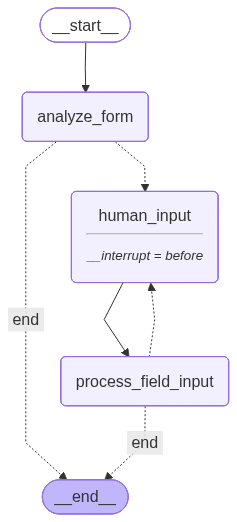

In [ ]:
# Create the memory saver for checkpointing
memory = MemorySaver()

# Create the graph
form_filler_graph = StateGraph(FormFillerState)

# Add nodes
form_filler_graph.add_node("analyze_form", analyze_form)
form_filler_graph.add_node("process_field_input", process_field_input)
form_filler_graph.add_node("human_input", human_input)

# Add edges
form_filler_graph.add_edge(START, "analyze_form")
form_filler_graph.add_conditional_edges(
    "analyze_form",
    route_next_step,
    {
        "human_input": "human_input",
        "end": END
    }
)
form_filler_graph.add_edge("human_input", "process_field_input")
form_filler_graph.add_conditional_edges(
    "process_field_input",
    route_next_step,
    {
        "human_input": "human_input",
        "end": END
    }
)

# Compile the graph
compiled_graph = form_filler_graph.compile(
    checkpointer=memory,
    interrupt_before=["human_input"]
)

# Display the graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## 9. Helper Functions for Working with the Graph

Let's create helper functions to start a new form-filling session and to continue an existing session.

In [ ]:
# Helper function to initialize the form-filling process
async def start_form_filling(user_message: str, form_fields: List[Dict]) -> Dict[str, Any]:
    """
    Initializes a new form-filling session.
    
    Args:
        user_message: The initial user message
        form_fields: List of form fields to fill
        
    Returns:
        Initial state and response information
    """
    thread_id = str(uuid4())
    
    initial_state = {
        "user_message": user_message,
        "form_fields": form_fields,
        "filled_fields": {},
        "missing_fields": [],
        "current_field": None,
        "conversation_history": [],
        "status": "in_progress",
        "response": ""
    }
    
    config = {"configurable": {"thread_id": thread_id}}
    
    print(f"Starting form filling session with thread_id: {thread_id}")
    result = await compiled_graph.ainvoke(initial_state, config)
    
    # Get the updated state
    state = compiled_graph.get_state(config)
    
    return {
        "thread_id": thread_id,
        "response": result["response"],
        "status": result["status"],
        "filled_fields": result["filled_fields"],
        "missing_fields": result["missing_fields"],
        "state": state
    }

# Helper function to continue the form-filling process
async def continue_form_filling(thread_id: str, user_message: str) -> Dict[str, Any]:
    """
    Continues an existing form-filling session.
    
    Args:
        thread_id: The conversation thread ID
        user_message: The user's response to the previous question
        
    Returns:
        Updated state and response information
    """
    config = {"configurable": {"thread_id": thread_id}}
    
    # Get current state
    state = compiled_graph.get_state(config)
    
    if not state:
        raise ValueError(f"No session found for thread_id {thread_id}")
    
    # Update state with new user message
    compiled_graph.update_state(config, {"user_message": user_message})
    
    # Continue graph execution
    print(f"Continuing form filling session with thread_id: {thread_id}")
    result = await compiled_graph.ainvoke(None, config)
    
    # Get the updated state
    state = compiled_graph.get_state(config)
    
    return {
        "thread_id": thread_id,
        "response": result["response"],
        "status": result["status"],
        "filled_fields": result["filled_fields"],
        "missing_fields": result["missing_fields"],
        "state": state
    }

## 10. Test with Sample Form Data

Let's test our form-filling agent with a sample registration form.

In [ ]:
# Define a sample registration form
sample_form = [
    {
        "field_id": "name",
        "label": "Full Name",
        "type": "text",
        "value": None,
        "required": True,
        "description": "Your legal first and last name"
    },
    {
        "field_id": "email",
        "label": "Email Address",
        "type": "email",
        "value": None,
        "required": True,
        "validation": "Must be a valid email address"
    },
    {
        "field_id": "phone",
        "label": "Phone Number",
        "type": "tel",
        "value": None,
        "required": True,
        "description": "Your contact phone number"
    },
    {
        "field_id": "address",
        "label": "Home Address",
        "type": "textarea",
        "value": None,
        "required": True,
        "description": "Your full mailing address"
    },
    {
        "field_id": "birthdate",
        "label": "Date of Birth",
        "type": "date",
        "value": None,
        "required": True,
        "description": "Format: YYYY-MM-DD"
    },
    {
        "field_id": "occupation",
        "label": "Occupation",
        "type": "select",
        "value": None,
        "required": True,
        "options": ["Student", "Engineer", "Doctor", "Teacher", "Other"],
        "description": "Your current occupation"
    }
]

## 11. Run the Form-Filling Workflow

Now let's simulate a complete form-filling session with our agent.

In [ ]:
# Function to simulate a complete conversation
async def simulate_form_filling():
    # Initial user message
    initial_message = "Hi, I'd like to register. My name is John Smith and my email is john.smith@example.com."
    
    print("🔵 User:", initial_message)
    
    # Start the form-filling process
    result = await start_form_filling(initial_message, sample_form)
    thread_id = result["thread_id"]
    
    print("🤖 Agent:", result["response"])
    print("📋 Filled fields:", result["filled_fields"])
    print("❓ Missing fields:", result["missing_fields"])
    print("-" * 50)
    
    # Continue with additional fields
    conversation_steps = [
        "My phone number is 555-123-4567",
        "I live at 123 Main Street, Anytown, CA 94043",
        "I was born on May 15, 1985",
        "I'm a Software Engineer"
    ]
    
    for message in conversation_steps:
        print("🔵 User:", message)
        result = await continue_form_filling(thread_id, message)
        print("🤖 Agent:", result["response"])
        print("📋 Filled fields:", result["filled_fields"])
        print("❓ Missing fields:", result["missing_fields"])
        print("-" * 50)
    
    return result

# Run the simulation
await simulate_form_filling()

🔵 User: Hi, I'd like to register. My name is John Smith and my email is john.smith@example.com.
Starting form filling session with thread_id: 7bdaa582-dbf5-41a5-9cb4-083b0cefabf1
Form analysis response: ```json
{
  "filled_fields": {
    "name": "John Smith",
    "email": "john.smith@example.com"
  },
  "missing_fields": ["phone", "address", "birthdate", "occupation"]
}
```
🤖 Agent: I need some additional information. Can you provide the Phone Number? (Your contact phone number)
📋 Filled fields: {'name': 'John Smith', 'email': 'john.smith@example.com'}
❓ Missing fields: ['phone', 'address', 'birthdate', 'occupation']
--------------------------------------------------
🔵 User: My phone number is 555-123-4567
Continuing form filling session with thread_id: 7bdaa582-dbf5-41a5-9cb4-083b0cefabf1
Form analysis response: ```json
{
  "filled_fields": {
    "name": "John Smith",
    "email": "john.smith@example.com"
  },
  "missing_fields": ["phone", "address", "birthdate", "occupation"]
}
```
🤖

{'thread_id': '7bdaa582-dbf5-41a5-9cb4-083b0cefabf1',
 'response': "Great! I've filled out the entire form. Here's a summary of the information:\n- Full Name: John Smith\n- Email Address: john.smith@example.com\n- Phone Number: 555-123-4567\n- Home Address: 123 Main Street, Anytown, CA 94043\n- Date of Birth: 1985-05-15\n- Occupation: Engineer",
 'status': 'completed',
 'filled_fields': {'name': 'John Smith',
  'email': 'john.smith@example.com',
  'phone': '555-123-4567',
  'address': '123 Main Street, Anytown, CA 94043',
  'birthdate': '1985-05-15',
  'occupation': 'Engineer'},
 'missing_fields': [],
 'state': StateSnapshot(values={'user_message': "I'm a Software Engineer", 'form_fields': [{'field_id': 'name', 'label': 'Full Name', 'type': 'text', 'value': None, 'required': True, 'description': 'Your legal first and last name'}, {'field_id': 'email', 'label': 'Email Address', 'type': 'email', 'value': None, 'required': True, 'validation': 'Must be a valid email address'}, {'field_id':

## 12. Customizing the Form-Filling Agent

You can customize the form-filling agent for different use cases:

1. **Multiple Form Types**: Extend the agent to handle different types of forms by adding a form identifier
2. **Validation Rules**: Add more sophisticated validation for field values
3. **Field Dependencies**: Handle fields that depend on other fields (e.g., state depends on country)
4. **Multi-Field Questions**: Ask for multiple related fields in one question
5. **Field Prioritization**: Ask for more important fields first

For production use, you would integrate this agent with:

1. A frontend that displays the form and agent responses
2. A proper database to store session state
3. Error handling and recovery mechanisms
4. Improved UX with suggested responses or options

## Conclusion

In this notebook, we've built a form-filling agent using LangGraph that can:

1. Extract information from initial user messages
2. Identify missing fields that require additional information
3. Ask clear, targeted questions to gather missing information
4. Complete the form when all required fields are filled

This pattern can be extended to handle many types of form-filling tasks, from simple registrations to complex applications, making it easier for users to provide information through natural conversation rather than structured forms.